In [1]:
%matplotlib inline



# Frequency and time-frequency sensor analysis

The objective is to show you how to explore the spectral content
of your data (frequency and time-frequency). Here we'll work on Epochs.

We will use this dataset: `somato-dataset`. It contains so-called event
related synchronizations (ERS) / desynchronizations (ERD) in the beta band.


In [2]:
# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Stefan Appelhoff <stefan.appelhoff@mailbox.org>
#          Richard Höchenberger <richard.hoechenberger@gmail.com>
#
# License: BSD (3-clause)
import os.path as op

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne.datasets import somato

Set parameters



In [6]:
data_path = somato.data_path()
subject = '01'
task = 'somato'
raw_fname = op.join(data_path, 'sub-{}'.format(subject), 'meg',
                    'sub-{}_task-{}_meg.fif'.format(subject, task))

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname)
events = mne.find_events(raw, stim_channel='STI 014')

# picks MEG gradiometers
picks = mne.pick_types(raw.info, meg='grad', eeg=True, eog=True, stim=False)

# Construct Epochs
event_id, tmin, tmax = 1, -1., 3.
baseline = (None, 0) #from tmin to 0/event
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=baseline, reject=dict(grad=4000e-13, eog=350e-6),
                    preload=True)

epochs.resample(200., npad='auto')  # resample to reduce computation time

Opening raw data file C:\Users\louis\mne_data\MNE-somato-data\sub-01\meg\sub-01_task-somato_meg.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.
111 events found
Event IDs: [1]
Not setting metadata
Not setting metadata
111 matching events found
Setting baseline interval to [-0.9989760657919393, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 111 events and 1202 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
3 bad epochs dropped


Number of events,108
Events,1: 108
Time range,-0.999 – 3.001 sec
Baseline,-0.999 – 0.000 sec


## Frequency analysis

We start by exploring the frequence content of our epochs.



Let's first check out all channel types by averaging across epochs.



    Using multitaper spectrum estimation with 7 DPSS windows


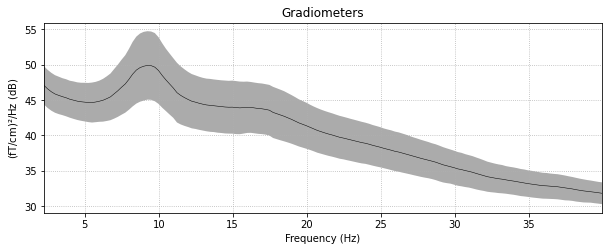

    Using multitaper spectrum estimation with 7 DPSS windows


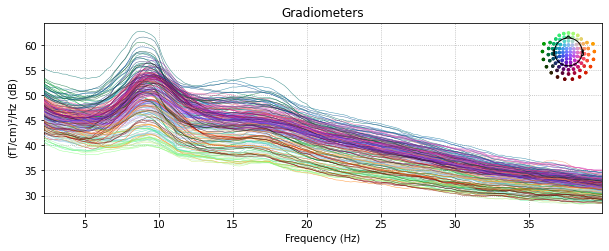

In [21]:
epochs.plot_psd(fmin=2., fmax=40., average=True, spatial_colors=False);
#psd = power spectral density
epochs.plot_psd(fmin=2., fmax=40., average=False, spatial_colors=True);
# clear 1/F power frequency relation... (it keeps dropping)
# if increasing fmax to e.g. 90 it is easy to see the 50hz noise...
# We downsampled to 200, so we cannot estiamte frequencies of above 100.

Now let's take a look at the spatial distributions of the PSD.



    Using multitaper spectrum estimation with 7 DPSS windows


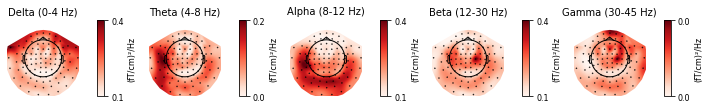

In [11]:
epochs.plot_psd_topomap(ch_type='grad', normalize=True); #change to EEG (grad)
#the above, but on topographies - somatosensory activity might be reflected as seen in beta

Alternatively, you can also create PSDs from Epochs objects with functions
that start with ``psd_`` such as
:func:`mne.time_frequency.psd_multitaper` and
:func:`mne.time_frequency.psd_welch`.



    Using multitaper spectrum estimation with 7 DPSS windows


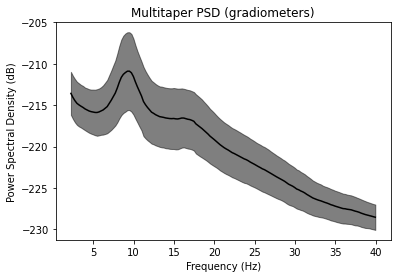

In [15]:
# a way to show what is actually happening in the functions above...
f, ax = plt.subplots()
psds, freqs = psd_multitaper(epochs, fmin=2, fmax=40, n_jobs=1)
psds = 10. * np.log10(psds)
psds_mean = psds.mean(0).mean(0)
psds_std = psds.mean(0).std(0)

ax.plot(freqs, psds_mean, color='k')
ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='k', alpha=.5)
ax.set(title='Multitaper PSD (gradiometers)', xlabel='Frequency (Hz)',
       ylabel='Power Spectral Density (dB)')
plt.show()

#not doing the root mean squared as the similar plot above
#looking for gamma - use multitaper, otherwise use the Welsch
#exploratory tools. You would rarely do statistics on this.

Notably, :func:`mne.time_frequency.psd_welch` supports the keyword argument
``average``, which specifies how to estimate the PSD based on the individual
windowed segments. The default is ``average='mean'``, which simply calculates
the arithmetic mean across segments. Specifying ``average='median'``, in
contrast, returns the PSD based on the median of the segments (corrected for
bias relative to the mean), which is a more robust measure.



Effective window size : 1.280 (s)
Effective window size : 1.280 (s)


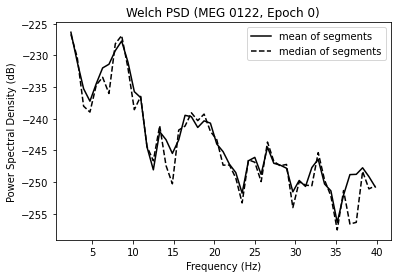

In [16]:
# Estimate PSDs based on "mean" and "median" averaging for comparison.
kwargs = dict(fmin=2, fmax=40, n_jobs=1) #kwargs = keyword arguments
psds_welch_mean, freqs_mean = psd_welch(epochs, average='mean', **kwargs)
psds_welch_median, freqs_median = psd_welch(epochs, average='median', **kwargs)

# Convert power to dB scale.
psds_welch_mean = 10 * np.log10(psds_welch_mean)
psds_welch_median = 10 * np.log10(psds_welch_median)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'MEG 0122'
ch_idx = epochs.info['ch_names'].index(ch_name)
epo_idx = 0

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_mean[epo_idx, ch_idx, :], color='k',
        ls='-', label='mean of segments')
ax.plot(freqs_median, psds_welch_median[epo_idx, ch_idx, :], color='k',
        ls='--', label='median of segments')

ax.set(title='Welch PSD ({}, Epoch {})'.format(ch_name, epo_idx),
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')
plt.show()

Lastly, we can also retrieve the unaggregated segments by passing
``average=None`` to :func:`mne.time_frequency.psd_welch`. The dimensions of
the returned array are ``(n_epochs, n_sensors, n_freqs, n_segments)``.



In [17]:
psds_welch_unagg, freqs_unagg = psd_welch(epochs, average=None, **kwargs)
print(psds_welch_unagg.shape)
#computationally efficient to segment - better for the Fourrier transform to segment it as here into 3 segments.

Effective window size : 1.280 (s)
(108, 204, 49, 3)



## Time-frequency analysis: power and inter-trial coherence

We now compute time-frequency representations (TFRs) from our Epochs.
We'll look at power and inter-trial coherence (ITC).

To this we'll use the function :func:`mne.time_frequency.tfr_morlet`
but you can also use :func:`mne.time_frequency.tfr_multitaper`
or :func:`mne.time_frequency.tfr_stockwell`.

<div class="alert alert-info"><h4>Note</h4><p>The ``decim`` parameter reduces the sampling rate of the time-frequency
      decomposition by the defined factor. This is usually done to reduce
      memory usage. For more information refer to the documentation of
      :func:`mne.time_frequency.tfr_morlet`.</p></div>

define frequencies of interest (log-spaced)



In [23]:
#freq we want to extract from our data + cycles (two hyperparameters put into the function - this is IMPORTANT - where you make or break your analysis)
#freqs = np.logspace(*np.log10([6, 35]), num=8)
#in not log-space
freqs = np.arange(6, 42, 2)

#for each frequency we want a different number of cycles (is also sometimes set as a fixed number e.g. 3 or 4 - especially investigating alpha or beta)
n_cycles = freqs / 2.  # different number of cycle per frequency (the more wiggles, the better temporal precision, but the worse frequency precision - n_cycles = number of wiggles in the wavelet)

#plot it into the function (using fast fourrier transform)
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1) #decim = we only estimate every third data point in our data - a way to speed up the computation
                        #njobs = number of kernels you want to use

In [29]:
freqs
#cohen has online resources on this

array([ 6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38,
       40])

## Inspect power

<div class="alert alert-info"><h4>Note</h4><p>The generated figures are interactive. In the topo you can click
    on an image to visualize the data for one sensor.
    You can also select a portion in the time-frequency plane to
    obtain a topomap for a certain time-frequency region.</p></div>



Applying baseline correction (mode: zscore)


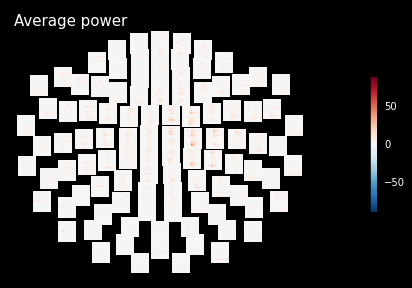

Applying baseline correction (mode: zscore)


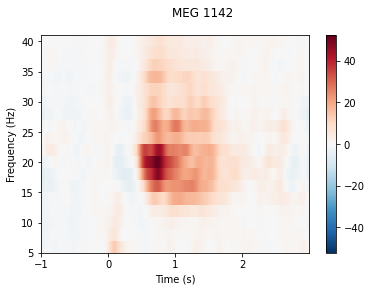

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


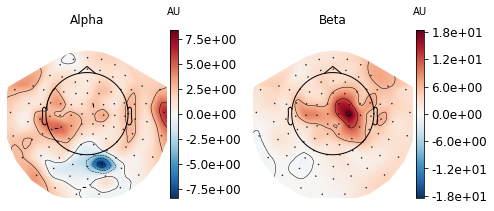

In [24]:
power.plot_topo(baseline=(-0.5, 0), mode='zscore', title='Average power'); #z-score, percentage, logratio etc. for mode - change the baseline
power.plot([82], baseline=(-0.5, 0), mode='zscore', title=power.ch_names[82]);

fig, axis = plt.subplots(1, 2, figsize=(7, 4))
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
                   baseline=(-0.5, 0), mode='zscore', axes=axis[0],
                   title='Alpha', show=False);
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=13, fmax=25,
                   baseline=(-0.5, 0), mode='zscore', axes=axis[1],
                   title='Beta', show=False);
mne.viz.tight_layout()
plt.show()

## Joint Plot
You can also create a joint plot showing both the aggregated TFR
across channels and topomaps at specific times and frequencies to obtain
a quick overview regarding oscillatory effects across time and space.



Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


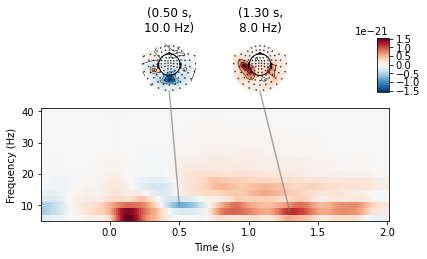

In [25]:
power.plot_joint(baseline=(-0.5, 0), mode='mean', tmin=-.5, tmax=2,
                 timefreqs=[(.5, 10), (1.3, 8)]);

## Inspect ITC



No baseline correction applied


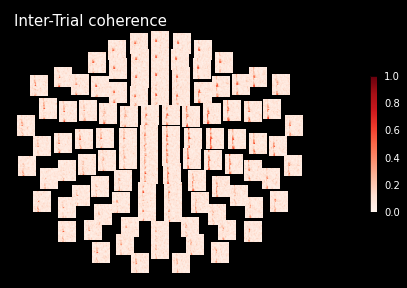

In [26]:
itc.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=1., cmap='Reds');

<div class="alert alert-info"><h4>Note</h4><p>Baseline correction can be applied to power or done in plots.
    To illustrate the baseline correction in plots, the next line is
    commented power.apply_baseline(baseline=(-0.5, 0), mode='logratio')</p></div>

## Exercise

   - Visualize the inter-trial coherence values as topomaps as done with
     power.



In [ ]:
#implementing the Hilbert if you get here...

No baseline correction applied
No baseline correction applied
No baseline correction applied


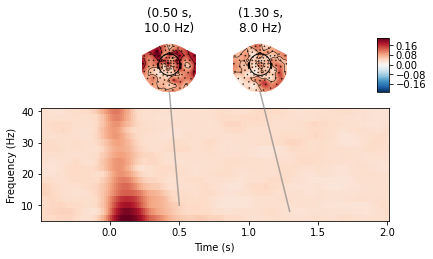

In [27]:
#we don't baseline correct ITCs (how aligned the phases are over trials - between 0 and 1) - because it is a bound measure
itc.plot_joint(tmin=-.5, tmax=2, timefreqs=[(.5, 10), (1.3, 8)]);

#you can see that there is a good phase-locking after the stimulation, and then it tapers off